Stochastic Volatilty Models

#### Home work 1

---

The file must be sent to **stoch-vol-23-fall@yandex.ru** with topic "stoch-vol HW1". WARNING: topic is important! Inbox will be filtered automatcally based on exact match. Please zip all files into one folder and rename it as "SurnameName_HW1" before sending.

Deadline: 2nd of November, 23:59.

<u>Full name</u>: **Safonova Elizaveta**

<u>Faculty</u>: ***Faculty of computational mathematics and cybernetics (CMC MSU)***

---

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm 
from py_vollib.black_scholes import black_scholes as bs
import matplotlib 
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [2]:
font = {'family':'Times New Roman', 'size': 10}
matplotlib.rc('font', **font)

### Problem 1 (20 points)

**1**. 💅 <span style="color:blue">(5 points)</span>  Calculate and plot **put** option prices in Black-Scholes model as functions of the underlying asset price for different **exercise times** and different **volatilities**. Use parameters 

$$K = 1, \quad r = 0, \quad S \in [0.5, 1.5],$$

and $T \in \{0,\ \frac{1}{4},\ \frac{1}{2},\ \frac{3}{4},\ 1\}$ (time is measured in years) and $\sigma \in \{0.1, \ 0.2, \ 0.3\}$.

*Note: the answer should contain three plots (for each volatility $\sigma$), each of which shows option prices for different excercise times $T$.*

## <u>***РЕШЕНИЕ***:</u>

In [3]:
r = 0
S = np.linspace(0.5, 1.5, 200)
K = 1
T = np.array([0, 0.25, 0.5, 0.75, 1])
sigma = np.array([0.1, 0.2, 0.3])

Put-call parity: $C- P = S - e^{-rT}K$

In [4]:
def Black_Scholes(r, S, K, T, sigma, type = "call"):
    
    "Calculate BS price of call/put option"
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * np.exp(- r * T) * norm.cdf(d2)

    if type == "call":
        return call_price
    elif type == "put":
        return call_price + K * np.exp(- r * T) - S
        
#print("Option Price: ", Black_Scholes(r, S, K, T, sigma, "call"))

In [5]:
prices_bs = np.zeros((sigma.size, T.size, S.size))
#print(prices_bs.shape)

In [6]:
for i, cur_sigma in enumerate(sigma):
    for j, cur_T in enumerate(T):
        for k, cur_S in enumerate(S):
            if j == 0:
                prices_bs[i][j][k] = np.maximum(K - cur_S, 0)
            else:
                prices_bs[i][j][k] = Black_Scholes(r, cur_S, K, cur_T, cur_sigma, type = "put")

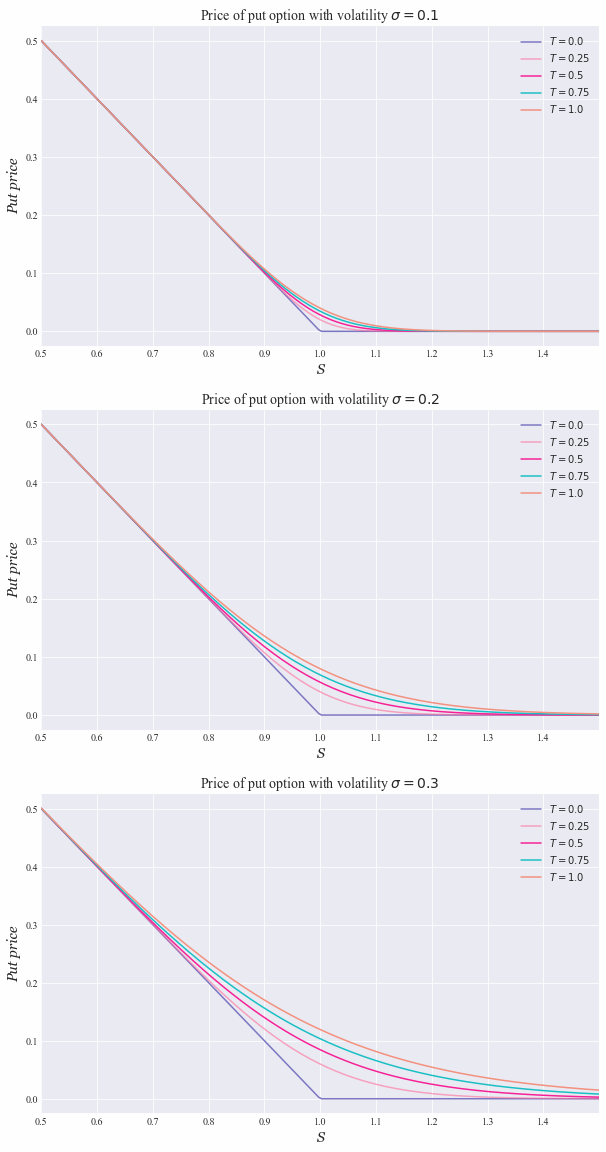

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))
for i in range(len(sigma)):
    for j in range(len(T)):
        ax[i].plot(S, prices_bs[i][j][:], label="$T={}$".format(T[j]))
        
    ax[i].set_title("Price of put option with volatility $\sigma={}$".format(sigma[i]), fontsize=14)     
    ax[i].set_xlabel("S", fontname = "Georgia", style="italic", fontsize = 14)
    ax[i].set_ylabel("Put price", fontname="Georgia", style="italic", fontsize=14) 
    ax[i].set_xlim([S[0], S[-1]])
    ax[i].set_xticks(np.arange(S[0], S[-1], 0.1))
    plt.rc('grid', linestyle = ":", color = '#B5B5B5')
    ax[i].set_axisbelow(True)
    plt.grid(True)
    ax[i].legend()

### Problem 1 (продолжение)

**2**. 💅 <span style="color:blue">(5 points)</span>  What kind of dependence on the parameters of put option price do you observe? How does the price of a put option change with changes in volatility, time to expiration? Why? Provide the intuition. 

## <u>***РЕШЕНИЕ***:</u>

При возрастании $S$ цена опциона put убывает. При увеличении волатильности $\sigma$ цена опциона put возрастает. При росте значения времени исполнения $T$ цена опциона put также возрастастает, за исключением случаев, когда опционы пут глубоко в деньгах при $r > 0$ (страйк значительно больше цены).

Интуитивно можно воспринимать опционы put (call) как страховку от того, что цена упадет (вырастет). Чем больше $T$, тем длительнее наша страховка, соответственно она и стоит дороже. При увеличении волатильности, цена акции становится более изменчивой, значит и растет модельный риск. Чем больше риск, тем выше стоимость страховки. $\blacksquare$

### Problem 1 (продолжение)

**3**. 💅 <span style="color:blue">(10 points)</span> Replicate considered put option using the portfolio rebalanced $n$ times (i.e. every $dt = T/n$ units of time). Using simulations, estimate the distribution of the replication error.


    1) Generate m random trajectories of price process trajectories on the segment [0,t] with a step dt = T/n.

    2) For each trajectory at each moment of time, find a replicating portfolio. Assume that the initial value of the portfolio is equal to the option price.

    3) For each trajectory, calculate the difference between the value of the replicating portfolio at time T and the payout to be made on the option.

    4) Display the distribution of the obtained differences in the form of a histogram.


*Note: use $m = 2^{10} - 1$ and $n$ = 123*. 

## <u>***РЕШЕНИЕ***:</u>

In [8]:
from typing import Union, Optional, Callable
from dataclasses import dataclass
import numpy.typing as npt

In [9]:
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

In [10]:
@dataclass
class MarketState:
    stock_price: Floats
    interest_rate: Floats
    time: Floats = 0

@dataclass
class StockOption:
    strike_price: Floats
    expiration_time: Floats  # in years
    is_call: Union[bool, npt.NDArray[np.bool_]]
    
    def payoff(self, stock_price: Floats) -> Floats:
        call_payoff = np.maximum(0, stock_price - self.strike_price)
        put_payoff = np.maximum(0, self.strike_price - stock_price)
        return np.where(self.is_call, call_payoff, put_payoff)

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        
@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)    

@dataclass
class BSParams:
    volatility: Floats

In [11]:
def dt(option: StockOption, ms: MarketState):
    return np.maximum(option.expiration_time - ms.time, np.finfo(np.float64).eps)


def d1(option: StockOption, ms: MarketState, params: BSParams):
    return 1 / (params.volatility * np.sqrt(dt(option, ms)))\
                * (np.log(ms.stock_price / option.strike_price)
                   + (ms.interest_rate + params.volatility ** 2 / 2) * dt(option, ms))


def d2(option: StockOption, ms: MarketState, params: BSParams):
    return d1(option, ms, params) - params.volatility * np.sqrt(dt(option, ms))

def price(option: StockOption, ms: MarketState, params: BSParams):
    discount_factor = np.exp(-ms.interest_rate * (dt(option, ms)))
    
    call_price = norm.cdf(d1(option, ms, params)) * ms.stock_price\
            - norm.cdf(d2(option, ms, params)) * option.strike_price * discount_factor
    put_price = norm.cdf(-d2(option, ms, params)) * option.strike_price * discount_factor\
        - norm.cdf(-d1(option, ms, params)) * ms.stock_price
    
    return np.where(option.is_call, call_price, put_price)

In [12]:
def make_bsm_market_simulator(
    ms: MarketState,
    params: BSParams,
    time_stop: float,
    n_steps: int = 123,
):
    
    def simulate(n_paths: int, seed: int = 1):
        dt = (time_stop - ms.time) / n_steps
        random = np.random.default_rng(seed)
        norm = random.normal(size=(n_paths, n_steps))
        d_log_s = (
            (ms.interest_rate - params.volatility ** 2 / 2) * dt
            + params.volatility * norm * np.sqrt(dt)
        )
        d_log_s = np.insert(d_log_s, 0, np.zeros(n_paths), axis=1)
        return ms.stock_price * np.exp(np.cumsum(d_log_s, axis=-1))
    
    return simulate

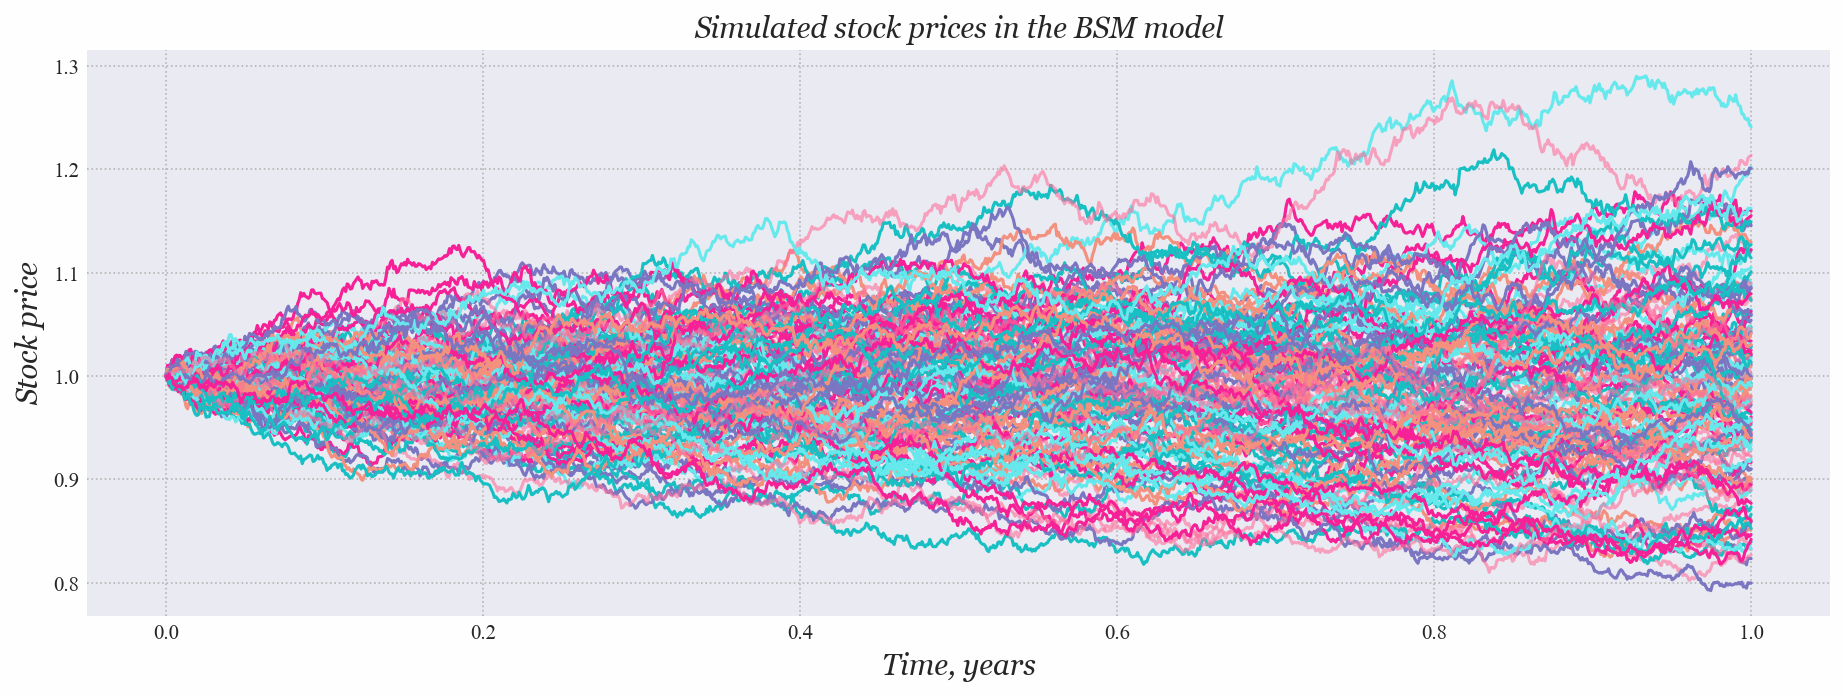

In [13]:
n = 123
m = 2**10 - 1
T = 1.0

ms = MarketState(stock_price=1, interest_rate=0.0)
params = BSParams(volatility=0.1)
sim_fn = make_bsm_market_simulator(ms, params, T, m)
paths = sim_fn(n)
t = np.linspace(0, T, m + 1)

_, ax = plt.subplots(figsize=(15, 5), dpi=150)
ax.plot(t, paths.T)
ax.set_xlabel("Time, years", fontname="Georgia", style="italic", fontsize=14)
ax.set_ylabel("Stock price", fontname="Georgia", style="italic", fontsize=14)
ax.set_title("Simulated stock prices in the BSM model", fontname="Georgia", style="italic", fontsize=14)
plt.show()

In [14]:
def delta(option: StockOption, ms: MarketState, params: BSParams):
    nd1 = norm.cdf(d1(option, ms, params))
    return np.where(option.is_call, nd1, nd1 - 1)

def calc_hedging_pnl(
    option: StockOption,
    ms: MarketState,
    params: BSParams,
    n_steps: int = 123,
    n_paths: int = 2**10-1,
    seed: int = 1,
):
    sim_fn = make_bsm_market_simulator(ms, params, option.expiration_time, n_steps)
    paths = sim_fn(n_paths, seed)                                            # paths.shape == (n_paths, n_steps + 1)
    times = np.linspace(ms.time, option.expiration_time, n_steps + 1)[None]  # times.shape == (1,       n_steps + 1)
    bank_acc = 1.0 * np.exp(ms.interest_rate * (times - times[:, 0]))
    df = 1.0 / bank_acc
    
    inter_ms = MarketState(
        stock_price=paths,
        interest_rate=ms.interest_rate,
        time=times,
    )
        
    opt_p = price(option, inter_ms, params)
    stock_pos = delta(option, inter_ms, params) 
    bank_acc_pos = df * (opt_p - stock_pos * paths)
    hedging_pnl = (
        stock_pos[:, :-1] * np.diff(paths, axis=-1)
        + bank_acc_pos[:, :-1] * np.diff(bank_acc, axis=-1)
    )
    payoff = -option.payoff(paths[:, [-1]])
    return np.append(hedging_pnl, payoff, axis=-1)

In [15]:
option = PutStockOption(strike_price=100.0, expiration_time=1.0)
ms = MarketState(stock_price=100.0, interest_rate=0.1)
params = BSParams(volatility=0.167)

In [16]:
pl = -calc_hedging_pnl(
    option,
    ms,
    params,
    n_paths=n,
    n_steps=m,
    seed=1,
).sum(-1)

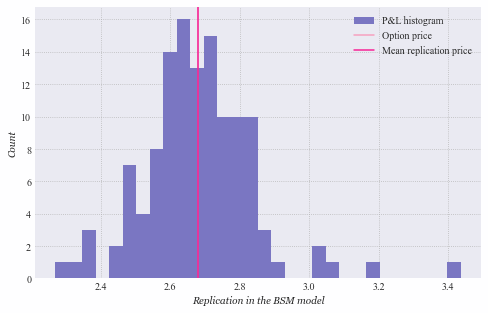

In [17]:
p = price(option, ms, params)

fig, ax = plt.subplots(figsize = (8, 5))
ax.hist(pl, bins=30, label="P&L histogram")
ax.axvline(p, c="C1", label="Option price")
ax.axvline(pl.mean(), c="C2", label="Mean replication price")
ax.set_xlabel("Replication in the BSM model", fontname="Georgia", style="italic")
ax.set_ylabel("Count", fontname="Georgia", style="italic")
ax.legend()
plt.show()

---

### Problem 2 (30 points)

**1**. 🧠 <span style="color:blue">(15 points)</span>  Consider the market with one riskless asset $B_t \equiv 1$ and risky asset $S_t$, given by the equations

$$dS_t = S_t (\mu dt + \sigma_t dW_t^{1}), \quad S_0 = 1,$$
$$\sigma_t = 1  + |W_t^{2}|,$$

where $W_t^{1}$ and $W_t^{2}$ are independent Brownian motions.

Prove that the market is not complete and provide an example of non-replicable bounded contingent claim.

## <u>***РЕШЕНИЕ***:</u>

В модели один рисковый актив ($N = 1$) и двумерное броуновское движение ($d = 2$). Рынок явлется полным, когда $N \geqslant d$, т.е. в нашем случае уже интуитивно понятно, что рынок неполный.

Предположим, что рынок полный. Тогда любое ограниченное $\mathcal{F}_T$ -измеримое платежное обязательство реплицируемо. В частности, любой индикатор $\mathbb{1}_{A}$ является достижимым платежным обязательством. Пусть $A = W_t^2 > 0$, $X_T = \mathbb{1}_{A}$, значит $X_T$ представимо в виде:

$$X_T =  G_t d B_t + \int_0^T H_t d S_t.$$

Для каждой траектории $S_t$ существуют два варианта броуновского движения: $W_t^2$ и $-W_t^2$, тогда $X_T = \mathbb{1}_{W_t^2 > 0} \neq \mathbb{1}_{(-W_t^2) > 0}$. В классе фильтрации, порожденной $S_t$ нет стратегии, которая удовлетворяет репликации обязательства. 

В классе $m(\mathcal{F_t})$, наверное, можно взять $X_T = −S_T$.

**2**. 🧠 <span style="color:blue">(15 points)</span>  For the model from the previous question find an equivalent martingale measure and calculate its Radon-Nikodym derivative with respect to the initial measure $P$.

## <u>***РЕШЕНИЕ***:</u>

Пусть $Q - EMM$, т.е. в мере $\mathbb{Q}$ динамика процесса $S_t$ описывается как $dS_t = f_td(W_t^1)^Q$ и $\mathbb{E}_t^Q = \mathbb{E}^Q(S_s | \mathcal{F}_t) = S_t$.

По теореме Гирсанова: $$(W_t^1)^Q = (W_t^1)^P + \int_0^t a_s ds$$

Подставляем $(W_t^1)P = (W_t^1)^Q - \int_0^t a_s ds$ в SDE для $S_t$ и получаем представвление в мере $\mathbb{Q}$:

$$dS_t = S_t (\mu dt + \sigma_t d(W_t^1)^Q - \sigma_t a_t dt) = f_td(W_t^1)^Q.$$

То есть $\mu - \sigma_t a_t = 0$, значит: $$a_t = \frac{\mu}{\sigma_t}.$$

Производная Радона-Никодима: $$\frac{d\mathbb{Q}}{d\mathbb{P}} = \exp(-\int_0^T \frac{\mu}{\sigma_s} dW_s^1 -\frac{1}{2}\int_0^T \frac{\mu^2}{\sigma_s^2} ds).\blacksquare$$ 

---

### Problem 3 (20 points)

Consider the no-arbitrage market consisting of risk-free asset $B_t$ with constant interest rate $r$ and risky asset $S_t > 0, t \in [0, T]$. Let $Q$ be a EMM for this market. 

🧠 <span style="color:blue">(10 points)</span> Show that for an arbitrage-free price of European call option 

$$C = \frac{B_0}{B_T} \mathbb{E}^{Q} (S_T - K)_{+}$$

the following representation holds

$$C = S_0 \tilde Q (S_T \geq K) - \frac{B_0}{B_T} K Q(S_t \geq K),$$

where $\tilde Q$ is some probability measure equilvanet to $Q$. 
  

## <u>***РЕШЕНИЕ***:</u>

$$C = \frac{B_0}{B_T} \mathbb{E}^{Q} (S_T - K)_+ = e^{-rT}\mathbb{E}^{Q}\left[(S_T - K)_+\right] = e^{-rT}\mathbb{E}^{Q}\left[(S_T - K)\mathbb{1}_{\{S_T \geqslant K\}}\right] = \mathbb{E}^{Q}\left[e^{-rT}S_T\mathbb{1}_{\{S_T \geqslant K\}}\right] - e^{-rT}K\mathbb{E}^{Q}\left[\mathbb{1}_{\{S_T \geqslant K\}}\right] =\\= B_0\mathbb{E}^{Q}\left[\frac{S_T}{B_T}\mathbb{1}_{\{S_T \geqslant K\}}\right] - \frac{B_0}{B_T}K\mathbb{Q}\left(S_T \geqslant K\right).$$

Замена нумерейро $(N, \mathbb{Q}^N)$:

$$B_t \mathbb{E}_t^{Q}\left[\frac{X_T}{B_T}\right] = N_t \mathbb{E}_t^{Q^N}\left[\frac{X_T}{N_T}\right].$$

В качестве нумерейро $N_t$ возьмем процесс $S_t$, это законно, т.к. его динамика соответствует динамике самофинансирующегося портфеля, $X_T = S_T\mathbb{1}_{\{S_T \geqslant K\}}$, тогда:

$$B_0\mathbb{E}^{Q}\left[\frac{S_T}{B_T}\mathbb{1}_{\{S_T \geqslant K\}}\right] = S_0\mathbb{E}^{Q^N}\left[\frac{S_T}{S_T}\mathbb{1}_{\{S_T \geqslant K\}}\right] = S_0\mathbb{E}^{Q^N}\left[\mathbb{1}_{\{S_T \geqslant K\}}\right] = S_0 \mathbb{Q}^N(S_T \geqslant K).$$

Итого имеем ($\tilde Q := \mathbb{Q}^N$): $$C = S_0 \mathbb{Q}^N(S_T \geqslant K) - \frac{B_0}{B_T}K\mathbb{Q}\left(S_T \geqslant K\right). \blacksquare$$

### Problem 3 (продолжение)

🧠 <span style="color:blue">(10 points)</span> Find the density $d \tilde Q / dQ$ and show that the process $B_t/S_t$ is a martingale with respect to $\tilde Q$. 

## <u>***РЕШЕНИЕ***:</u>

$$\frac{d \mathbb{Q}^N}{d \mathbb{Q}} = \frac{S_T}{B_T}\frac{B_0}{S_0},$$

$$\mathbb{E}^{Q^N}\left[S_0\mathbb{1}_{\{S_T \geqslant K\}}\right] = \mathbb{E}^{Q}\left[\frac{d \mathbb{Q}^N}{d \mathbb{Q}}S_0\mathbb{1}_{\{S_T \geqslant K\}}\right] = \mathbb{E}^{Q}\left[\frac{S_T}{B_T}\frac{B_0}{S_0}S_0\mathbb{1}_{\{S_T \geqslant K\}}\right] = B_0\mathbb{E}^{Q}\left[\frac{S_T}{B_T}\mathbb{1}_{\{S_T \geqslant K\}}\right]$$

$$\mathbb{E}^Q \left[\frac{d \mathbb{Q}^N}{d \mathbb{Q}}\right] = \mathbb{E}^Q \left[e^{-\frac{\sigma^2}{2}T + \sigma W_T^Q}\right] = \left[x = \sigma W_T^Q \sim N\left(0, (\sigma\sqrt{T})^2)\right)\right] = \int_{-\infty}^{+\infty} e^{-\frac{\sigma^2}{2}T + x}\frac{1}{\sigma\sqrt{2\pi T}}e^{-\frac{x^2}{2\sigma^2 T}}dx =\\=\int_{-\infty}^{+\infty} \frac{1}{\sigma\sqrt{2\pi T}}e^{-\frac{(x-\sigma^2 T)^2}{2\sigma^2 T}}dx = \frac{\sqrt{\pi}}{\sqrt{\pi}} = 1$$

Докажем, что $\frac{B_t}{S_t} -$ мартингал в мере $\mathbb{Q}^N$. $\frac{B_t}{S_t} \in \mathcal{L}_1$, т.к.

$$ E^{Q^N} \left|\frac{B_t}{S_t}\right| = E^Q \left[\frac{B_t}{S_t} \frac{S_0}{B_T} \frac{B_0}{S_0}\right] = \frac{B_0}{S_0} E^Q\left(E^Q \left[\frac{B_t}{S_t} \frac{S_T}{B_T} \Biggl| \mathcal{F}_t\right]\right) = \frac{B_0}{S_0} E^Q\left(\frac{B_t}{S_t}  E^Q \left[\frac{S_T}{B_T} \Biggl| \mathcal{F}_t\right]\right) = \frac{B_0}{S_0} E^Q\left(\frac{B_t}{S_t} \frac{S_t}{B_t} \right)\frac{B_0}{S_0} < \infty$$

т.е. нам осталось доказать только мартингальное свойство. 

Запишем динамику относительно меры $\mathbb{Q}$:

$$dB_t = rB_tdt,$$

$$dS_t = S_t(r dt + \sigma dW_t^Q).$$

Т.к. $\frac{d \mathbb{Q}^N}{d \mathbb{Q}}\Biggl|_{\scriptscriptstyle \mathcal{F}_t}= e^{-\frac{\sigma^2}{2}T + \sigma W_T^Q}$, то следующий процесс является винеровским:

$$W_t^{Q^N} = W_t^Q - \sigma t,$$

Динамика в мере $\mathbb{Q}^N$:

$$dB_t = rB_tdt,$$

$$dS_t = S_t\left((r + \sigma^2)dt + dW_t^{Q^N}\right).$$

$$\mathbb{E}_u^{Q^N}\left[\frac{B_t}{S_t}\right] = \mathbb{E}_u^{Q^N}\left[\frac{e^{-rt}}{S_0e^{(r + \sigma^2 - \frac{1}{2}\sigma^2) t + \sigma W_t^{Q^N}}}\right] = \frac{1}{S_0}\mathbb{E}_u^{Q^N}\left[e^{-\frac{1}{2}\sigma^2 t - \sigma W_t^{Q^N}}\right] = \frac{1}{S_0}e^{-\frac{1}{2}\sigma^2 t}\mathbb{E}_u^{Q^N}\left[e^{- \sigma(W_t^{Q^N} - W_u^{Q^N}) -\sigma W_u^{Q^N}}\right] = \\ = \frac{1}{S_0}e^{-\frac{1}{2}\sigma^2 t-\sigma W_u^{Q^N}}\mathbb{E}_u^{Q^N}\left[e^{- \sigma(W_t^{Q^N} - W_u^{Q^N})}\right] = \\= \frac{1}{S_0}e^{-\frac{1}{2}\sigma^2 t-\sigma W_u^{Q^N}}\mathbb{E}^{Q^N}\left[e^{- \sigma(W_t^{Q^N} - W_u^{Q^N})}\right] = \\=\frac{1}{S_0}e^{-\frac{1}{2}\sigma^2 t-\sigma W_u^{Q^N}}e^{\frac{\sigma^2(t-u)}{2}}\int_{-\infty}^{+\infty} \frac{1}{\sigma\sqrt{2\pi(t-u)}}e^{-\frac{(x+\sigma^2(t-u))^2}{2\sigma^2 (t-u)}}dx = \frac{1}{S_0}e^{-\frac{1}{2}\sigma^2 u-\sigma W_u^{Q^N}} = \frac{e^{ru}}{S_0 e^{(r+\frac{1}{2}\sigma^2)u + \sigma W_u^{Q^N}}} = \frac{B_u}{S_u}. \blacksquare$$

---

### Problem 4 (30 points)

Suppose the spot stock price and the price of the bond with maturity $T$ have the following dynamics under $ \tilde P$:

$$dB(t,T)=r_t B(t,T)dt + \sigma_t^{B} B(t,T) dW_t^{B}, \quad dS_t = r_t S_tdt + \sigma_t^{S} S_t dW_t^{S},$$
where $r_t$, $\rho_t$, $\sigma_t^{B}$, $\sigma_t^{S}$ are some random processes, and $W^{B}$, $W^{S}$ are correlated
Brownian motions, $dW_t^{B}dW_t^{S} = \rho_tdt$. 

🧠 <span style="color:blue">(15 points)</span>  Show that for the T-forward price $F_t$ we have 

$$dF_t = \mu_t^{F} F_t dt + \sigma_t^{F} F_t dW_t^{F},$$

where 

$$\mu_t^{F} = \sigma_t^{B} (\sigma_t^{B} - \rho_t \sigma_t^{S}), \quad \sigma_t^{F} = \sqrt{(\sigma_t^{S})^2 - 2 \rho_t \sigma_t^{S} \sigma_t^{B} + (\sigma_t^{B})^2}, \quad dW_t^{F} = \frac{1}{\sigma_t^{F}}(\sigma_t^{S} dW_t^{S} - \sigma_t^{B} dW_t^{B}).$$
 
*Hint*: apply Ito's formula to $S_t = B(t, T) F_t.$

## <u>***РЕШЕНИЕ***:</u>

Воспользуемся Ito's product rule для процесса $S_t = B(t, T) F_t$: 

$$
dS_t = F_tdB(t, T) + B(t,T)dF_t + dB(t,T)\cdot dF_t =\\= F_tdB(t, T) + B(t, T)(1 + r_tdt + \sigma_t^{B} dW_t^{B})dF_t.
$$

Пусть SDE для форвардной цены $F_t$ выглядит следующим образом: 

$$
dF_t = a_tF_tdt + b_tF_tdW_t^S + c_tF_tdW_t^B.
$$

Подставляем данные из условий задачи и выражений выше:

$$
dS_t = r_t S_tdt + \sigma_t^{S} S_t dW_t^{S} =\\= F_t r_t B(t,T)dt + F_t \sigma_t^{B} B(t,T) dW_t^{B} + B(t, T) F_t (1 + r_t dt+\sigma_t^{B} dW_t^{B})(a_tdt + b_tdW_t^S + c_tdW_t^B) =\\= F_t r_t B(t,T)dt + F_t \sigma_t^{B} B(t,T) dW_t^{B} + B(t, T) F_t\bigl(a_tdt + b_tdW_t^S + c_tdW_t^B + \sigma_t^{B} b_t \rho_t dt + \sigma_t^{B} c_t dt\bigr) =\\=  F_t B(t,T) \Bigl(\bigl(r_t + a_t + b_t \sigma_t^B \rho_t + c_t \sigma_t^B\bigr) dt + \bigl(c_t + \sigma_t^B\bigr)dW_t^B + b_t dW_t^S\Bigr).
$$

Приравниваем коэффициенты при $dt$, $dW_t^B$, $dW_t^S$:

$$dt: r_t S_t = F_t B(t,T) (r_t + a_t + b_t \sigma_t^B \rho_t + c_t \sigma_t^B), \quad\quad dW_t^B: 0 = F_t B(t,T)(\sigma_t^B + c_t), \quad\quad dW_t^S: \sigma_t^S S_t = F_t B(t, T) b_t.$$

В итоге получаем:

\begin{equation*}
b_t = \frac{\sigma_t^S S_t}{F_t B(t,T)} = \begin{bmatrix}
S_t = F_t B(t,T)\\
\end{bmatrix} = \sigma_t^S,
\end{equation*}

$$c_t = -\sigma_t^B,$$

$$a_t = \frac{r_t S_t}{F_t B(t,T)} - r_t - b_t \sigma_t^B \rho_t - c_t \sigma_t^B = \begin{bmatrix}
S_t = F_t B(t,T)\\
\end{bmatrix} = -b_t \sigma_t^B \rho_t - c_t \sigma_t^B = {(\sigma_t^B)}^2 - \sigma_t^S \sigma_t^B \rho_t.$$

$$dF_t = F_t\Bigl(\bigl({(\sigma_t^B)}^2 - \sigma_t^S \sigma_t^B \rho_t\bigr)dt + \sigma_t^S dW_t^S - \sigma_t^B dW_t^B\Bigr) = \mu_t^{F} F_t dt + \sigma_t^{F} F_t dW_t^{F}.$$

Т.е. $\mu_t^{F}$ в действительности равно $\mu_t^{F} = \sigma_t^{B} (\sigma_t^{B} - \rho_t \sigma_t^{S})$. Найдем теперь $\sigma_t^{F}$ и $dW_t^{F}$:

$$\sigma_t^S dW_t^S - \sigma_t^B dW_t^B = \sigma_t^{F}dW_t^{F}.$$

Следовательно, $dW_t^{F} = \frac{1}{\sigma_t^{F}}(\sigma_t^{S} dW_t^{S} - \sigma_t^{B} dW_t^{B})$.

$$(\sigma_t^S dW_t^S - \sigma_t^B dW_t^B)^2 = \Bigl((\sigma_t^S)^2 - 2\rho_t \sigma_t^S \sigma_t^B +  (\sigma_t^B)^2\Bigr) dt = (\sigma_t^{F}dW_t^{F})^2 = (\sigma_t^{F})^2 dt.$$

Значит, $\sigma_t^{F} = \sqrt{(\sigma_t^{S})^2 - 2 \rho_t \sigma_t^{S} \sigma_t^{B} + (\sigma_t^{B})^2}$. $\blacksquare$

### Problem 4 (продолжение)

🧠 <span style="color:blue">(15 points)</span> Show that under the forward measure $Q^T$ associated with $\tilde P$ by the Radon-Nikodym derivative 

$$Z_t := \frac{dQ^{T}_t}{d \tilde P_t} = \frac{B(t, T) / B_t}{B(0, T) / B_0},$$


we have 

$$ dF^{T}_t = \sigma_t^{F} F^{T}_t d\tilde W_t^{F}, $$
$$d B(t, T) = \mu_t^{B} B(t, T) dt + \sigma_t^{B} B(t, T) d \tilde W_t^{B},$$
$$dS_t = \mu_t^{S} S_t dt + \sigma_t^{S} S_t d \tilde W_t^{S},$$

where $\tilde W^{F}, \tilde W^{B}, \tilde W^{S}$ are Brownian motions and 

$$\mu_t^{B} = r_t + (\sigma_t^{B})^2,$$
$$\mu_t^{S} = r_t + \rho_t \sigma_t^{S} \sigma_t^{B},$$
$$\sigma_t^{S} = \rho_t \sigma_t^{B} + \sqrt{(\sigma_t^{F})^{2} - (1 - \rho_t^{2}) (\sigma_t^{B})^2}.$$

## <u>***РЕШЕНИЕ***:</u>

Представим $dW_t^S = \rho_t dW_t^B + \sqrt{1 - \rho_t^2} dM_t$, где $dM_t dW_t^B = 0$.

$$dB(t,T)=r_t B(t,T)dt + \sigma_t^{B} B(t,T) dW_t^{B}$$
$$dS_t = r_t S_tdt + \sigma_t^{S} S_t\left(\rho_t dW_t^B + \sqrt{1 - \rho_t^2} dM_t\right),$$

Матрица волатильности:

$$\begin{bmatrix}
\sigma_t^B & 0\\
\sigma_t^S\rho_t & \sigma_t^S\sqrt{1 - \rho_t^2}
\end{bmatrix}
$$

$$\frac{d\mathbb{Q}^T}{d \mathbb{\tilde P}}\Biggl|_{\scriptscriptstyle \mathcal{F}_t} = Z_t$$

$$dZ_t = d\left(\frac{B(t, T)B_0}{B(0, T) B_t}\right) = \frac{B_0}{B(0, T)}d\left(\frac{B(t, T)}{B_t}\right) = \frac{B_0}{B(0, T)}\left[B(t, T)d\left(\frac{1}{B_t}\right) + \frac{1}{B_t} d B(t,T) + d\left(\frac{1}{B_t}\right)  d B(t,T) \right]$$

$$d\left(\frac{1}{B_t}\right) = -\frac{r_t dt}{B_t}$$

Тогда:

$$
dZ_t = Z_t(r_t dt + \sigma_t^B dW_t^B - r_t dt + 0) = Z_t \sigma_t^B dW_t^B = 
\begin{pmatrix}
\sigma_t^B, &0
\end{pmatrix}
\begin{bmatrix}
dW_t^B\\
dM_t
\end{bmatrix}
$$

По теореме Гирсанова следующие процессы $\tilde W_t^{B}, \tilde M_t$ в мере $\mathbb{Q}^T$ винеровские:

$$d \tilde W_t^B = dW_t^B - \sigma_t^B dt$$

$$d \tilde M_t = dM_t$$

Подставляем $dW_t^B = d \tilde W_t^B + \sigma_t^B dt$ и $d \tilde M_t = dM_t$ в изначальные SDE:

$$dB(t,T) = r_t B(t,T)dt + \sigma_t^{B} B(t,T)\left(d \tilde W_t^B + \sigma_t^B dt\right) =\\= \underbrace{(r_t + (\sigma_t^{B})^2)}_{\mu_t^B}B(t,T)dt + \sigma_t^{B} B(t,T)d \tilde W_t^B ) = \\ = \mu_t^{B} B(t, T) dt + \sigma_t^{B} B(t, T) d \tilde W_t^{B}$$

$$dS_t = r_t S_tdt + \sigma_t^{S} S_t dW_t^{S} = r_t S_tdt + \sigma_t^{S} S_t\left(\rho_t dW_t^B + \sqrt{1 - \rho_t^2} dM_t\right) = r_t S_tdt + \sigma_t^{S} S_t\left(\rho_t \left(d \tilde W_t^B + \sigma_t^B dt\right) + \sqrt{1 - \rho_t^2} d \tilde M_t\right) =\\= \underbrace{\left(r_t + \sigma_t^{S} \rho_t \sigma_t^B\right)}_{\mu_t^S}S_t dt + \sigma_t^{S} S_t\underbrace{\left(\rho_t d \tilde W_t^B + \sqrt{1 - \rho_t^2} d \tilde M_t\right)}_{d \tilde W_t^S} = \\ = \mu_t^{S} S_t dt + \sigma_t^{S} S_t d \tilde W_t^{S}$$

$$dF_t = \mu_t^{F} F_t dt + \sigma_t^{F} F_t \frac{1}{\sigma_t^{F}}\left[\sigma_t^{S}\left(\rho_t (d \tilde W_t^B + \sigma_t^B dt) + \sqrt{1 - \rho_t^2} d \tilde M_t\right) - \sigma_t^{B} \left(d \tilde W_t^B + \sigma_t^B dt\right)\right] = \\ = F_t\left(\underbrace{\mu_t^{F} dt+ \rho_t \sigma_t^S \sigma_t^B dt- (\sigma_t^B)^2dt}_{= \; 0} + \underbrace{\rho_t \sigma_t^S d \tilde W_t^B + \sigma_t^S \sqrt{1 - \rho_t^2} d \tilde M_t}_{\sigma_t^S d \tilde W_t^S} - \sigma_t^B d \tilde W_t^B\right) = \\ = F_t\left(\sigma_t^S d \tilde W_t^S - \sigma_t^B d \tilde W_t^B\right) = F_t \sigma_t^F d \tilde W_t^F. \blacksquare$$
